# Spike for online Bayesian inference on MNIST
> Ignorance is strength

In [ ]:
# hide
import blackhc.project.script

Appended /home/blackhc/PycharmProjects/bald-ical/src to paths
Switched to directory /home/blackhc/PycharmProjects/bald-ical
%load_ext autoreload
%autoreload 2


In [ ]:
from batchbald_redux import online_bayesian_inference

In [ ]:
import collections
import functools
import math
import os
import re
from collections import namedtuple
from dataclasses import dataclass
from typing import NamedTuple

import laaos
import pandas as pd
import seaborn as sns

In [ ]:
# https://codereview.stackexchange.com/questions/85311/transform-snake-case-to-camelcase
def camel_case_name(snake_case_name):
    return re.sub("_([a-z])", lambda match: match.group(1).upper(), snake_case_name)


__namedtuples = {}


def to_namedtuple(obj, name):
    type_name = "_" + camel_case_name(name)
    if isinstance(obj, dict):
        keys = tuple(obj.keys())
        if keys in __namedtuples:
            nt = __namedtuples[keys]
        else:
            nt = namedtuple(type_name, keys)
            __namedtuples[keys] = nt
        return nt(*(to_namedtuple(v, k) for k, v in obj.items()))
    if isinstance(obj, list):
        item_type_name = type_name + "Item"
        return [to_namedtuple(item, item_type_name) for item in obj]
    if isinstance(obj, set):
        item_type_name = type_name + "Item"
        return {to_namedtuple(item, item_type_name) for item in obj}
    if isinstance(obj, tuple):
        item_type_name = type_name + "Item"
        return tuple(to_namedtuple(item, item_type_name) for item in obj)

    return obj


def get_any(d: dict):
    return next(iter(d.values()))


def handle_map_funcs(func_kv, func_k, func_v, default=None):
    if func_kv:
        assert func_k is None and func_v is None

        def inner(kv):
            return func_kv(*kv)

    elif func_k:
        assert func_v is None

        def inner(kv):
            return func_k(kv[0]), kv[1]

    elif func_v:

        def inner(kv):
            return kv[0], func_v(kv[1])

    else:
        return default
    return inner


def handle_unary_funcs(pred_kv, pred_k, pred_v, default=None):
    if pred_kv:
        assert pred_k is None and pred_v is None

        def inner(kv):
            return pred_kv(*kv)

    elif pred_k:
        assert pred_v is None

        def inner(kv):
            return pred_k(kv[0])

    elif pred_v:

        def inner(kv):
            return pred_v(kv[1])

    else:
        return default
    return inner


def map_dict(d: dict, *, kv=None, k=None, v=None):
    inner = handle_map_funcs(kv, k, v)
    return dict(map(inner, d.items()))


def filter_dict(d: dict, *, kv=None, k=None, v=None):
    inner_pred = handle_unary_funcs(kv, k, v)
    return dict(filter(inner_pred, d.items()))


def sort_dict(d: dict, *, reverse=False, kv=None, k=None, v=None):
    inner_key = handle_unary_funcs(kv, k, v, default=lambda ikv: ikv[0])
    return dict(sorted(d.items(), key=inner_key, reverse=reverse))


def groupby_dict(d: dict, *, key_kv=None, key_k=None, key_v=None, agg=None):
    inner_key = handle_unary_funcs(key_kv, key_k, key_v)

    grouped_by = {}
    for kv in d.items():
        new_key = inner_key(kv)
        if new_key not in grouped_by:
            grouped_by[new_key] = {}
        key, value = kv
        grouped_by[new_key][key] = value

    if agg is not None:
        return map_dict(grouped_by, v=agg)

    return grouped_by

In [ ]:
def get_laaos_files(laaos_dir=None):
    if laaos_dir is None:
        laaos_dir = "./batchbald_redux/results"

    laaos_files = {}
    for root, dirs, files in os.walk(laaos_dir, topdown=False):
        for name in files:
            if not name.endswith(".py"):
                continue

            rel_path = os.path.join(root, name)
            result_name = rel_path[len(laaos_dir) :]
            abs_path = os.path.abspath(rel_path)
            laaos_files[result_name] = abs_path

    return laaos_files


def load_laaos_files(path=None, files=None, vanilla=False, tag=None, prefix=None):
    if files is None:
        files = get_laaos_files(path)

    stores = {}
    for name, path in files.items():

        def nan():
            pass

        store = laaos.safe_load(path, exposed_symbols=[nan])
        store["actual_name"] = name
        store["actual_path"] = path
        store["tag"] = tag

        key = f"{prefix}{name}" if prefix is not None else name
        stores[key] = store

    if vanilla:
        return stores
    else:
        return map_dict(stores, v=functools.partial(to_namedtuple, name="Result"))

In [ ]:
results = {}

In [ ]:
results.update(load_laaos_files("./results/xmi_mnist_clean"))

In [ ]:
get_any(results).config

_config(seed=12, acquisition_size=1, max_training_set=300, num_pool_samples=100, num_validation_samples=20, num_training_samples=1, num_patience_epochs=20, max_training_epochs=120, training_batch_size=64, device='cuda', validation_set_size=1024, initial_training_set_size=20, min_samples_per_epoch=1024, repeated_mnist_repetitions=1, add_dataset_noise=False, acquisition_function='batchbald_redux.acquisition_functions.BALD', train_eval_model='batchbald_redux.train_eval_model.TrainSelfDistillationEvalModel', model_optimizer_factory='batchbald_redux.models.MnistOptimizerFactory', acquisition_function_args=None, temperature=8)

In [ ]:
timestamps = pd.DataFrame.from_records(
    [dict(job_id=result.job_id, timestamp=result.timestamp) for result in results.values()]
)

In [ ]:
timestamps

,job_id,timestamp
0,8,1621292074
1,6,1621286684
2,9,1622897637
3,14,1621293068
4,6,1622897604
5,11,1621292710
6,5,1621286163
7,1,1621280258
8,7,1622897593
9,13,1621293126


<AxesSubplot:xlabel='job_id', ylabel='timestamp'>

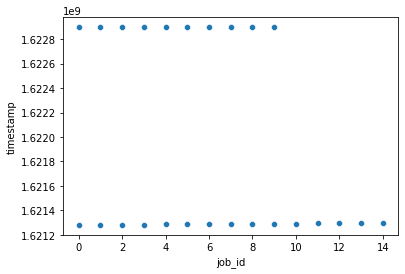

In [ ]:
grd = sns.scatterplot(data=timestamps, x="job_id", y="timestamp")
grd

In [ ]:
seed_acq_size_function_result = {}

for result in results.values():
    if not hasattr(result, "config"):
        print(file, "empty")
        continue

    seed_acq_size_function_result[
        (result.config.seed, result.config.acquisition_size, result.config.acquisition_function)
    ] = result

len(seed_acq_size_function_result), len(results)
# list(sorted(seed_acq_size_function_result.keys()))

(25, 25)

```
configs = [
            Experiment(
                seed=seed,
                acquisition_function=AcquisitionFunction.bald,
                acquisition_size=acquisition_size,
                num_pool_samples=num_pool_samples,
            )
            for seed in range(5)
            for acquisition_size in [5, 10, 20, 50]
            for num_pool_samples in [10, 20, 50, 100]
        ] + [
            Experiment(
                seed=seed,
                acquisition_function=AcquisitionFunction.random,
                acquisition_size=5,
                num_pool_samples=20,
            )
            for seed in range(20)
        ]
```

In [ ]:
experiment_data = []

for file, result in results.items():
    if not hasattr(result, "config"):
        print(file, "empty")
        continue

    if "xmi_labels_clean" in file:
        xmi_type = "cleaned"
    elif "xmi_pred" in file:
        xmi_type = "pred"
    elif "xmi_labels" in file:
        xmi_type = "label"
    else:
        raise Exception("xmi_type")

    acquisition_size = result.config.acquisition_size
    acquisition_function = result.config.acquisition_function[len("batchbald_redux.acquisition_functions.") :]
    num_pool_samples = result.config.num_pool_samples

    if result.timestamp < 1624000000 and xmi_type == "cleaned" and acquisition_function == "BatchCoreSetBALD":
        print(file, "skipping (old BatchCoreSetBALD)")
        continue
    elif xmi_type == "cleaned" and acquisition_function == "BatchCoreSetBALD":
        print(file, "keeping (BatchCoreSetBALD)")

    seed = result.config.seed

    if acquisition_function == "Random":
        acquisition_sizes = [1, 5, 10]
    else:
        acquisition_sizes = [acquisition_size]

    if acquisition_function == "Random":
        num_pool_samples = [100]
    else:
        num_pool_samples = [num_pool_samples]

    for nps in num_pool_samples:
        for acquisition_size in acquisition_sizes:
            initial_set_size = len(result.initial_training_set_indices)

            if (
                initial_set_size
                + sum(1 if hasattr(step, "evaluation_metrics") else 0 for step in result.active_learning_steps)
                * result.config.acquisition_size
                < 120
            ):
                print(len(result.active_learning_steps), file)
                continue

            for i, step in enumerate(result.active_learning_steps):
                if not hasattr(step, "evaluation_metrics"):
                    break
                training_set_size = initial_set_size + i * result.config.acquisition_size
                accuracy = step.evaluation_metrics.accuracy

                experiment_data.append(
                    dict(
                        xmi_type=xmi_type,
                        acquisition_function=acquisition_function,
                        acquisition_size=acquisition_size,
                        num_pool_samples=nps,
                        training_set_size=training_set_size,
                        accuracy=accuracy,
                        seed=seed,
                    )
                )

/experiment_xmi_labels_clean_job_9_2021-06-05-135357.py skipping (old BatchCoreSetBALD)
/experiment_xmi_labels_clean_job_6_2021-06-05-135324.py skipping (old BatchCoreSetBALD)
/experiment_xmi_labels_clean_job_7_2021-06-05-135313.py skipping (old BatchCoreSetBALD)
/experiment_xmi_labels_clean_job_0_2021-06-05-134550.py skipping (old BatchCoreSetBALD)
/experiment_xmi_labels_clean_job_5_2021-06-05-135306.py skipping (old BatchCoreSetBALD)
/experiment_xmi_labels_clean_job_1_2021-06-05-134534.py skipping (old BatchCoreSetBALD)
/experiment_xmi_labels_clean_job_4_2021-06-05-134523.py skipping (old BatchCoreSetBALD)
/experiment_xmi_labels_clean_job_3_2021-06-05-134542.py skipping (old BatchCoreSetBALD)
/experiment_xmi_labels_clean_job_8_2021-06-05-135338.py skipping (old BatchCoreSetBALD)
/experiment_xmi_labels_clean_job_2_2021-06-05-134519.py skipping (old BatchCoreSetBALD)


In [ ]:
df = pd.DataFrame.from_records(experiment_data)

In [ ]:
df

,xmi_type,acquisition_function,acquisition_size,num_pool_samples,training_set_size,accuracy,seed
0,cleaned,BALD,1,100,20,0.5537,12
1,cleaned,BALD,1,100,21,0.6340,12
2,cleaned,BALD,1,100,22,0.6395,12
3,cleaned,BALD,1,100,23,0.6205,12
4,cleaned,BALD,1,100,24,0.6218,12
...,...,...,...,...,...,...,...
3660,cleaned,BALD,1,100,296,0.9714,0
3661,cleaned,BALD,1,100,297,0.9735,0
3662,cleaned,BALD,1,100,298,0.9737,0
3663,cleaned,BALD,1,100,299,0.9736,0


In [ ]:
df.acquisition_size.unique()

array([ 1,  5, 10])

In [ ]:
num_trials_by_acquisition_size_and_function = (
    df.query("training_set_size == 20").groupby(["acquisition_size", "xmi_type"])["acquisition_function"].value_counts()
)
num_trials_by_acquisition_size_and_function.name = "num_trials"
print(num_trials_by_acquisition_size_and_function)

num_trials_by_acquisition_size_and_function = num_trials_by_acquisition_size_and_function.reset_index()

acquisition_size  xmi_type  acquisition_function
1                 cleaned   BALD                    5
                            CoreSetBALD             5
                            Random                  5
5                 cleaned   Random                  5
10                cleaned   Random                  5
Name: num_trials, dtype: int64


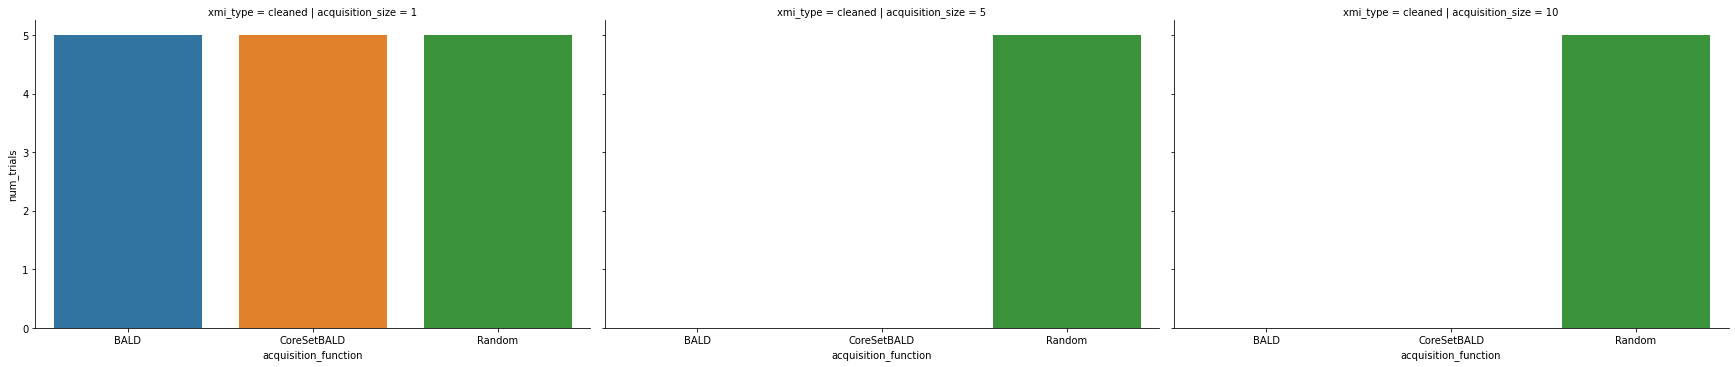

In [ ]:
grd = sns.catplot(
    data=num_trials_by_acquisition_size_and_function,
    kind="bar",
    y="num_trials",
    x="acquisition_function",
    col="acquisition_size",
    row="xmi_type",
    aspect=1.6,
)
grd.fig.patch.set_alpha(1)

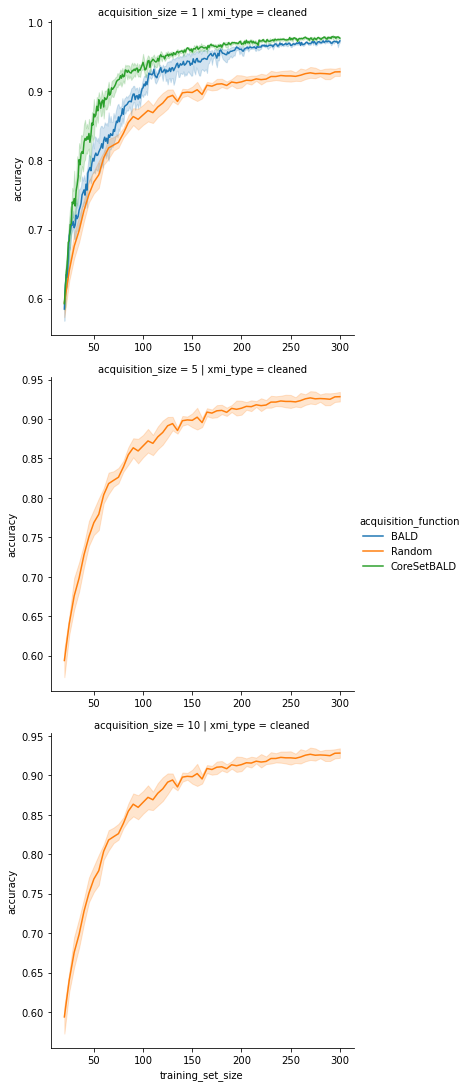

In [ ]:
grd = sns.relplot(
    x="training_set_size",
    y="accuracy",
    # col="acquisition_size",
    col="xmi_type",
    row="acquisition_size",
    hue="acquisition_function",
    data=df,
    kind="line",
    height=5,
    facet_kws=dict(sharex=False, sharey=False),
)

grd.fig.patch.set_alpha(1)

# Grab the active learning training set

In [ ]:
list(results.keys())

['/experiment_xmi_labels_clean_job_8_2021-05-17-235434.py',
 '/experiment_xmi_labels_clean_job_6_2021-05-17-222444.py',
 '/experiment_xmi_labels_clean_job_9_2021-06-05-135357.py',
 '/experiment_xmi_labels_clean_job_14_2021-05-18-001108.py',
 '/experiment_xmi_labels_clean_job_6_2021-06-05-135324.py',
 '/experiment_xmi_labels_clean_job_11_2021-05-18-000510.py',
 '/experiment_xmi_labels_clean_job_5_2021-05-17-221603.py',
 '/experiment_xmi_labels_clean_job_1_2021-05-17-203738.py',
 '/experiment_xmi_labels_clean_job_7_2021-06-05-135313.py',
 '/experiment_xmi_labels_clean_job_13_2021-05-18-001206.py',
 '/experiment_xmi_labels_clean_job_7_2021-05-17-222523.py',
 '/experiment_xmi_labels_clean_job_0_2021-06-05-134550.py',
 '/experiment_xmi_labels_clean_job_5_2021-06-05-135306.py',
 '/experiment_xmi_labels_clean_job_10_2021-05-17-235725.py',
 '/experiment_xmi_labels_clean_job_1_2021-06-05-134534.py',
 '/experiment_xmi_labels_clean_job_3_2021-05-17-203747.py',
 '/experiment_xmi_labels_clean_job_2

In [ ]:
result_coresetbald = {
    key: result
    for key, result in results.items()
    if "batchbald_redux.acquisition_functions.CoreSetBALD" == result.config.acquisition_function
}

In [ ]:
list(result_coresetbald.keys())

['/experiment_xmi_labels_clean_job_5_2021-05-17-221603.py',
 '/experiment_xmi_labels_clean_job_1_2021-05-17-203738.py',
 '/experiment_xmi_labels_clean_job_7_2021-05-17-222523.py',
 '/experiment_xmi_labels_clean_job_3_2021-05-17-203747.py',
 '/experiment_xmi_labels_clean_job_9_2021-05-17-235707.py']

In [ ]:
result = results["/experiment_xmi_labels_clean_job_5_2021-05-17-221603.py"]

In [ ]:
result.initial_training_set_indices, len(result.initial_training_set_indices)

([46377,
  44390,
  7485,
  25450,
  12220,
  43112,
  3612,
  54256,
  44467,
  17555,
  4218,
  45101,
  41296,
  32261,
  3281,
  6944,
  7701,
  30692,
  24891,
  24436],
 20)

In [ ]:
len(result.active_learning_steps)

281

In [ ]:
result.active_learning_steps[55 - 20].evaluation_metrics.accuracy

0.9005

In [ ]:
result.active_learning_steps[55 - 20]

_ActiveLearningStepsItem(training=_training(epochs=[_EpochsItem(accuracy=0.236328125, crossentropy=2.243678092956543), _EpochsItem(accuracy=0.4521484375, crossentropy=1.8996704816818237), _EpochsItem(accuracy=0.642578125, crossentropy=1.4321852922439575), _EpochsItem(accuracy=0.8447265625, crossentropy=1.0597556829452515), _EpochsItem(accuracy=0.88671875, crossentropy=0.7888789772987366), _EpochsItem(accuracy=0.923828125, crossentropy=0.7004990577697754), _EpochsItem(accuracy=0.92578125, crossentropy=0.6723615527153015), _EpochsItem(accuracy=0.916015625, crossentropy=0.669696033000946), _EpochsItem(accuracy=0.9169921875, crossentropy=0.6594111323356628), _EpochsItem(accuracy=0.9248046875, crossentropy=0.6549736857414246), _EpochsItem(accuracy=0.9111328125, crossentropy=0.6851381063461304), _EpochsItem(accuracy=0.921875, crossentropy=0.5839430093765259), _EpochsItem(accuracy=0.9267578125, crossentropy=0.5901234745979309), _EpochsItem(accuracy=0.94140625, crossentropy=0.5539214611053467)

In [ ]:
training_set_90 = list(result.initial_training_set_indices)

for step in result.active_learning_steps[: 55 - 20]:
    training_set_90 += step.acquisition.indices

In [ ]:
training_set_90, len(training_set_90)

([46377,
  44390,
  7485,
  25450,
  12220,
  43112,
  3612,
  54256,
  44467,
  17555,
  4218,
  45101,
  41296,
  32261,
  3281,
  6944,
  7701,
  30692,
  24891,
  24436,
  2748,
  34,
  8009,
  27203,
  54180,
  39513,
  45801,
  34608,
  57338,
  37095,
  5474,
  7304,
  13153,
  49406,
  4820,
  7865,
  7863,
  42303,
  2942,
  52175,
  57842,
  9472,
  16908,
  12585,
  29130,
  29839,
  49509,
  6947,
  18501,
  12422,
  3742,
  19362,
  43169,
  44202,
  22497],
 55)

# Retrain to 90% with 55 samples

In [ ]:
# Rerun from 2022/04/15

training_set_90 = [
    46377,
    44390,
    7485,
    25450,
    12220,
    43112,
    3612,
    54256,
    44467,
    17555,
    4218,
    45101,
    41296,
    32261,
    3281,
    6944,
    7701,
    30692,
    24891,
    24436,
    17776,
    36852,
    26891,
    17001,
    44414,
    23050,
    30884,
    41516,
    8897,
    34608,
    11721,
    13127,
    9870,
    39700,
    13985,
    9608,
    17808,
    23028,
    3494,
    10210,
    42384,
    31742,
    17100,
    46530,
    26733,
    4762,
    14113,
    20798,
    28388,
    42973,
    37347,
    55042,
    41295,
    28310,
    19280,
    18501,
    274,
    11208,
    13335,
    24440,
    49493,
    58129,
    56210,
    40766,
    13318,
    50040,
    18408,
    7255,
    15494,
    7168,
    9472,
    14845,
    14096,
    26072,
    35944,
    34836,
    12655,
    991,
    38577,
    47322,
    45212,
    16286,
    5308,
    38182,
    31624,
    12702,
    30861,
    46320,
    36408,
    49841,
    33426,
    57527,
    3273,
    24740,
    39627,
    22199,
    19362,
    42136,
    41965,
    43095,
]

In [ ]:
# Extracted from stored, old results

training_set_90 = [
    46377,
    44390,
    7485,
    25450,
    12220,
    43112,
    3612,
    54256,
    44467,
    17555,
    4218,
    45101,
    41296,
    32261,
    3281,
    6944,
    7701,
    30692,
    24891,
    24436,
    2748,
    34,
    8009,
    27203,
    54180,
    39513,
    45801,
    34608,
    57338,
    37095,
    5474,
    7304,
    13153,
    4820,
    49406,
    7865,
    7863,
    42303,
    2942,
    52175,
    57842,
    9472,
    16908,
    12585,
    29130,
    29839,
    49509,
    6947,
    18501,
    12422,
    3742,
    19362,
    43169,
    44202,
    22497,
]

In [ ]:
import dataclasses
import traceback
from dataclasses import dataclass
from typing import Type, Union

import torch
import torch.utils.data
from blackhc.project import is_run_from_ipython
from blackhc.project.experiment import embedded_experiments
from torch.utils.data import Dataset

import batchbald_redux.acquisition_functions as acquisition_functions
from batchbald_redux.acquisition_functions import (
    CandidateBatchComputer,
    EvalModelBatchComputer,
)
from batchbald_redux.active_learning import ActiveLearningData, RandomFixedLengthSampler
from batchbald_redux.black_box_model_training import evaluate_old, train
from batchbald_redux.dataset_challenges import (
    AdditiveGaussianNoise,
    NamedDataset,
    create_repeated_MNIST_dataset,
    get_balanced_sample_indices,
    get_base_dataset_index,
    get_target,
)
from batchbald_redux.di import DependencyInjection
from batchbald_redux.fast_mnist import FastMNIST
from batchbald_redux.model_optimizer_factory import ModelOptimizerFactory
from batchbald_redux.models import MnistOptimizerFactory

In [ ]:
# From the BatchBALD Repo
from batchbald_redux.train_eval_model import (
    TrainEvalModel,
    TrainSelfDistillationEvalModel,
)
from batchbald_redux.trained_model import TrainedBayesianModel

In [ ]:
from blackhc.progress_bar import create_progress_bar
from toma import toma


def compute_entropy_from_probs(probs_N_K_C: torch.Tensor) -> torch.Tensor:
    N, K, C = probs_N_K_C.shape

    entropies_N = torch.empty(N, dtype=torch.double)

    pbar = create_progress_bar(N, tqdm_args=dict(desc="Entropy", leave=False))
    pbar.start()

    @toma.execute.chunked(probs_N_K_C, 1024)
    def compute(probs_n_K_C, start: int, end: int):
        mean_probs_n_C = probs_n_K_C.mean(dim=1)
        nats_n_C = mean_probs_n_C * torch.log(mean_probs_n_C)
        nats_n_C[mean_probs_n_C == 0] = 0.0

        entropies_N[start:end].copy_(-torch.sum(nats_n_C, dim=1))
        pbar.update(end - start)

    pbar.finish()

    return entropies_N

In [ ]:
@dataclass
class Experiment:
    seed: int = 1337
    acquisition_size: int = 5
    max_training_set: int = 300
    num_pool_samples: int = 20
    num_validation_samples: int = 20
    num_training_samples: int = 1
    num_patience_epochs: int = 5 * 4
    max_training_epochs: int = 30 * 4
    training_batch_size: int = 64
    device: str = "cuda"
    validation_set_size: int = 1024
    initial_training_set_size: int = 20
    min_samples_per_epoch: int = 1024
    acquisition_function: Union[Type[CandidateBatchComputer], Type[EvalModelBatchComputer]] = acquisition_functions.BALD
    train_eval_model: TrainEvalModel = TrainSelfDistillationEvalModel
    model_optimizer_factory: Type[ModelOptimizerFactory] = MnistOptimizerFactory
    acquisition_function_args: dict = None
    temperature: float = 0.0

    def load_dataset(self) -> (ActiveLearningData, Dataset, Dataset):
        train_dataset = NamedDataset(
            FastMNIST("data", train=True, download=True, device=self.device), "FastMNIST (train)"
        )
        train_predictions = torch.load("./data/mnist_train_predictions.pt", map_location=self.device)
        # train_dataset = train_dataset.override_targets(targets=train_predictions.argmax(dim=1))

        train_entropies = compute_entropy_from_probs(train_predictions[:, None, :])

        allowed_indices = torch.nonzero(train_entropies < 0.01, as_tuple=True)[0].numpy()
        print(f"Removing {len(train_dataset) - len(allowed_indices)} training samples with entropy >= 0.01.")
        allowed_train_dataset = train_dataset.subset(allowed_indices)
        fixed_initial_set_indices = [
            allowed_train_dataset.get_base_dataset_index(i).index for i in training_set_90[:20]
        ]

        active_learning_data = ActiveLearningData(train_dataset)

        fixed_set = fixed_initial_set_indices + training_set_90[20:69]
        print(fixed_set)
        active_learning_data.acquire_base_indices(fixed_set)

        validation_dataset = active_learning_data.extract_dataset_from_pool(self.validation_set_size)
        validation_dataset = NamedDataset(
            validation_dataset, f"FastMNIST (validation, {len(validation_dataset)} samples)"
        )

        test_dataset = FastMNIST("data", train=False, device=None)
        test_dataset = NamedDataset(test_dataset, f"FastMNIST (test, {len(test_dataset)} samples)")

        return active_learning_data, validation_dataset, test_dataset, training_set_90

    # Simple Dependency Injection
    def create_acquisition_function(self):
        di = DependencyInjection(vars(self))
        return di.create_dataclass_type(self.acquisition_function)

    def create_train_eval_model(self, runtime_config) -> TrainEvalModel:
        config = {**vars(self), **runtime_config}
        di = DependencyInjection(config, [])
        return di.create_dataclass_type(self.train_eval_model)

    def run(self, store):
        torch.manual_seed(self.seed)

        # Active Learning setup
        active_learning_data, validation_dataset, test_dataset, initial_training_set_indices = self.load_dataset()
        store["initial_training_set_indices"] = initial_training_set_indices
        store["dataset_info"] = dict(training=repr(active_learning_data.base_dataset), test=repr(test_dataset))

        # initial_training_set_indices = active_learning_data.get_random_pool_indices(self.initial_set_size)
        # initial_training_set_indices = get_balanced_sample_indices(
        #     active_learning_data.pool_dataset, 10, self.initial_set_size // 10
        # )

        train_loader = torch.utils.data.DataLoader(
            active_learning_data.training_dataset,
            batch_size=64,
            sampler=RandomFixedLengthSampler(active_learning_data.training_dataset, self.min_samples_per_epoch),
            drop_last=True,
        )
        pool_loader = torch.utils.data.DataLoader(
            active_learning_data.pool_dataset, batch_size=128, drop_last=False, shuffle=False
        )

        validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=128, drop_last=False)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, drop_last=False)

        store["active_learning_steps"] = []
        active_learning_steps = store["active_learning_steps"]

        acquisition_function = self.create_acquisition_function()

        training_set_size = len(active_learning_data.training_dataset)
        print(f"Training set size {training_set_size}:")

        # iteration_log = dict(training={}, pool_training={}, evaluation_metrics=None, acquisition=None)
        active_learning_steps.append({})
        iteration_log = active_learning_steps[-1]

        iteration_log["training"] = {}

        model_optimizer = self.model_optimizer_factory().create_model_optimizer()

        double_snapshots = None
        if training_set_size > 0:
            train(
                model=model_optimizer.model,
                optimizer=model_optimizer.optimizer,
                training_samples=self.num_training_samples,
                validation_samples=self.num_validation_samples,
                train_loader=train_loader,
                validation_loader=validation_loader,
                patience=self.num_patience_epochs,
                max_epochs=self.max_training_epochs,
                device=self.device,
                training_log=iteration_log["training"],
                wandb_key_path="",
            )

        evaluation_metrics = evaluate_old(
            model=model_optimizer.model,
            num_samples=self.num_validation_samples,
            loader=test_loader,
            device=self.device,
        )
        iteration_log["evaluation_metrics"] = evaluation_metrics
        print(f"Perf after training {evaluation_metrics}")
        return model_optimizer.model

In [ ]:
experiment = Experiment(
    seed=7,
    acquisition_function=acquisition_functions.CoreSetBALD,
    acquisition_size=1,
    num_pool_samples=100,
    temperature=8,
    device="cuda",
)

In [ ]:
logs = {}
model = experiment.run(logs)
logs

Entropy:   0%|          | 0/60000 [00:00<?, ?it/s]

Removing 5678 training samples with entropy >= 0.01.
[51348, 49110, 8222, 28130, 13484, 47685, 3938, 59930, 49196, 19427, 4601, 49922, 45635, 35684, 3579, 7621, 8465, 33959, 27521, 27015, 17776, 36852, 26891, 17001, 44414, 23050, 30884, 41516, 8897, 34608, 11721, 13127, 9870, 39700, 13985, 9608, 17808, 23028, 3494, 10210, 42384, 31742, 17100, 46530, 26733, 4762, 14113, 20798, 28388, 42973, 37347, 55042, 41295, 28310, 19280, 18501, 274, 11208, 13335, 24440, 49493, 58129, 56210, 40766, 13318, 50040, 18408, 7255, 15494]
Creating: CoreSetBALD(
	acquisition_size=1,
	num_pool_samples=100
)
Training set size 69:


  1%|          | 1/120 [00:00<?, ?it/s]

[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.1865234375, 'crossentropy': 2.204674243927002}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.3984375, 'crossentropy': 1.8883782625198364}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.7724609375, 'crossentropy': 1.3038113117218018}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.8505859375, 'crossentropy': 0.9791264533996582}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.884765625, 'crossentropy': 0.7918858528137207}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.8720703125, 'crossentropy': 0.6580309271812439}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.8720703125, 'crossentropy': 0.6301825046539307}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.87890625, 'crossentropy': 0.5223856568336487}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.880859375, 'crossentropy': 0.5107243061065674}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.876953125, 'crossentropy': 0.504318356513977}
RestoringEarlyStopping: 5 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.8720703125, 'crossentropy': 0.48791268467903137}
RestoringEarlyStopping: 6 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.873046875, 'crossentropy': 0.47130918502807617}
RestoringEarlyStopping: 7 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.876953125, 'crossentropy': 0.4586462378501892}
RestoringEarlyStopping: 8 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.873046875, 'crossentropy': 0.48082560300827026}
RestoringEarlyStopping: 9 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.8759765625, 'crossentropy': 0.45325061678886414}
RestoringEarlyStopping: 10 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.8662109375, 'crossentropy': 0.4505855143070221}
RestoringEarlyStopping: 11 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.896484375, 'crossentropy': 0.39331504702568054}


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.865234375, 'crossentropy': 0.44815850257873535}
RestoringEarlyStopping: 1 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.87109375, 'crossentropy': 0.44715559482574463}
RestoringEarlyStopping: 2 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.890625, 'crossentropy': 0.41086944937705994}
RestoringEarlyStopping: 3 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.8740234375, 'crossentropy': 0.420120507478714}
RestoringEarlyStopping: 4 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.880859375, 'crossentropy': 0.44895458221435547}
RestoringEarlyStopping: 5 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.8779296875, 'crossentropy': 0.43646499514579773}
RestoringEarlyStopping: 6 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.892578125, 'crossentropy': 0.4303978681564331}
RestoringEarlyStopping: 7 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.8671875, 'crossentropy': 0.44779253005981445}
RestoringEarlyStopping: 8 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.890625, 'crossentropy': 0.40923184156417847}
RestoringEarlyStopping: 9 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.8857421875, 'crossentropy': 0.4240313172340393}
RestoringEarlyStopping: 10 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.8662109375, 'crossentropy': 0.4461303651332855}
RestoringEarlyStopping: 11 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.8662109375, 'crossentropy': 0.45511895418167114}
RestoringEarlyStopping: 12 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.8779296875, 'crossentropy': 0.426716148853302}
RestoringEarlyStopping: 13 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.8955078125, 'crossentropy': 0.43110382556915283}
RestoringEarlyStopping: 14 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.8701171875, 'crossentropy': 0.4675087034702301}
RestoringEarlyStopping: 15 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.8857421875, 'crossentropy': 0.42910146713256836}
RestoringEarlyStopping: 16 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.884765625, 'crossentropy': 0.43076467514038086}
RestoringEarlyStopping: 17 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.8916015625, 'crossentropy': 0.416121244430542}
RestoringEarlyStopping: 18 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.8896484375, 'crossentropy': 0.4155978560447693}
RestoringEarlyStopping: 19 / 20


[1/16]   6%|6          [00:00<?]

Epoch metrics: {'accuracy': 0.8876953125, 'crossentropy': 0.408776193857193}
RestoringEarlyStopping: 20 / 20
RestoringEarlyStopping: Out of patience
RestoringEarlyStopping: Restoring best parameters. (Score: 0.896484375)
RestoringEarlyStopping: Restoring optimizer.
{'/val_metrics': <wandb.data_types.Table object at 0x7f5644227370>, '/best_epoch': 16, '/best_val_accuracy': 0.896484375, '/best_val_crossentropy': 0.39331504702568054}


[1/79]   1%|1          [00:00<?]

Perf after training {'accuracy': 0.9048, 'crossentropy': 0.378577880859375}


{'initial_training_set_indices': [46377,
  44390,
  7485,
  25450,
  12220,
  43112,
  3612,
  54256,
  44467,
  17555,
  4218,
  45101,
  41296,
  32261,
  3281,
  6944,
  7701,
  30692,
  24891,
  24436,
  17776,
  36852,
  26891,
  17001,
  44414,
  23050,
  30884,
  41516,
  8897,
  34608,
  11721,
  13127,
  9870,
  39700,
  13985,
  9608,
  17808,
  23028,
  3494,
  10210,
  42384,
  31742,
  17100,
  46530,
  26733,
  4762,
  14113,
  20798,
  28388,
  42973,
  37347,
  55042,
  41295,
  28310,
  19280,
  18501,
  274,
  11208,
  13335,
  24440,
  49493,
  58129,
  56210,
  40766,
  13318,
  50040,
  18408,
  7255,
  15494,
  7168,
  9472,
  14845,
  14096,
  26072,
  35944,
  34836,
  12655,
  991,
  38577,
  47322,
  45212,
  16286,
  5308,
  38182,
  31624,
  12702,
  30861,
  46320,
  36408,
  49841,
  33426,
  57527,
  3273,
  24740,
  39627,
  22199,
  19362,
  42136,
  41965,
  43095],
 'dataset_info': {'training': "'FastMNIST (train)'",
  'test': "'FastMNIST (test, 10000

In [ ]:
device = "cuda"
train_dataset = NamedDataset(FastMNIST("data", train=True, download=True, device=device), "FastMNIST (train)")

test_dataset = FastMNIST("data", train=False, device=device)
test_dataset = NamedDataset(test_dataset, f"FastMNIST (test, {len(test_dataset)} samples)")

In [ ]:
online_bayesian_inference.evaluate_online_bayesian_inference(
    model,
    real_training_set_size=69,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    additional_training_indices=training_set_90[69:72],
    num_samples_list=[10, 100],
    num_trials=10,
    up_factor=4,
    eval_batchsize=512,
    device="cuda"
)

get_predictions_labels:   0%|          | 0/4001200 [00:00<?, ?it/s]

Online Training Size/Num Samples/Trial: 0/10/0
OBIPerformance(total_training_set_size=69, real_training_set_size=69, online_training_set_size=0, trial_index=0, num_samples=10, accuracy=0.9053000211715698, crossentropy=0.36478863752452756)
Online Training Size/Num Samples/Trial: 0/10/1
OBIPerformance(total_training_set_size=69, real_training_set_size=69, online_training_set_size=0, trial_index=1, num_samples=10, accuracy=0.8996999859809875, crossentropy=0.36229836322350656)
Online Training Size/Num Samples/Trial: 0/10/2
OBIPerformance(total_training_set_size=69, real_training_set_size=69, online_training_set_size=0, trial_index=2, num_samples=10, accuracy=0.8970999717712402, crossentropy=0.38442623740958404)
Online Training Size/Num Samples/Trial: 0/10/3
OBIPerformance(total_training_set_size=69, real_training_set_size=69, online_training_set_size=0, trial_index=3, num_samples=10, accuracy=0.9082000255584717, crossentropy=0.36399307377589557)
Online Training Size/Num Samples/Trial: 0/10

[OBIPerformance(total_training_set_size=69, real_training_set_size=69, online_training_set_size=0, trial_index=0, num_samples=10, accuracy=0.9053000211715698, crossentropy=0.36478863752452756),
 OBIPerformance(total_training_set_size=69, real_training_set_size=69, online_training_set_size=0, trial_index=1, num_samples=10, accuracy=0.8996999859809875, crossentropy=0.36229836322350656),
 OBIPerformance(total_training_set_size=69, real_training_set_size=69, online_training_set_size=0, trial_index=2, num_samples=10, accuracy=0.8970999717712402, crossentropy=0.38442623740958404),
 OBIPerformance(total_training_set_size=69, real_training_set_size=69, online_training_set_size=0, trial_index=3, num_samples=10, accuracy=0.9082000255584717, crossentropy=0.36399307377589557),
 OBIPerformance(total_training_set_size=69, real_training_set_size=69, online_training_set_size=0, trial_index=4, num_samples=10, accuracy=0.8938999772071838, crossentropy=0.3908146566503921),
 OBIPerformance(total_training_

In [ ]:
sub_train_set = train_dataset * 0.1
joint_set = sub_train_set + test_dataset

In [ ]:
len(sub_train_set)

6000

In [ ]:
joint_loader = torch.utils.data.DataLoader(joint_set, batch_size=128, drop_last=False, shuffle=False)

# Model Sampling

In [ ]:
predictions_N_M_C, labels_N = model.get_predictions_labels(
    num_samples=10000, loader=joint_loader, device="cuda", storage_device="cpu"
)

get_predictions_labels:   0%|          | 0/160000000 [00:00<?, ?it/s]

In [ ]:
predictions_N_M_C.shape

torch.Size([16000, 10000, 10])

In [ ]:
offset = 0
virtual_training_set_size = 5  # len(training_set_90)
evidence_factor = 0.2

In [ ]:
true_train_predictions_n_M = predictions_N_M_C[
    list(range(offset, offset + virtual_training_set_size)), :, labels_N[offset : offset + virtual_training_set_size]
]

In [ ]:
true_train_predictions_n_M.shape

torch.Size([5, 10000])

In [ ]:
mix_weights_M = torch.sum(true_train_predictions_n_M, dim=0)  # / (virtual_training_set_size*evidence_factor)

In [ ]:
mix_weights_M.shape

torch.Size([10000])

In [ ]:
mix_weights_M

tensor([-15.3410, -11.1278, -14.9485,  ..., -13.4631, -14.4733, -15.4444])

<AxesSubplot:ylabel='Density'>

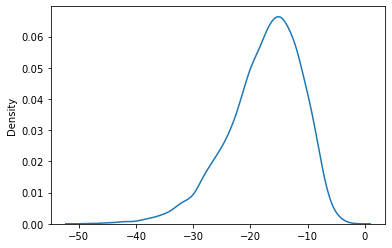

In [ ]:
sns.kdeplot(mix_weights_M.numpy())

In [ ]:
split_joints = mix_weights_M[None, :, None] + predictions_N_M_C[len(sub_train_set) :]  # [:, mix_weights_M > -40, :]

In [ ]:
# predictions_N = torch.argmax(torch.logsumexp(split_joints, dim=1), dim=1)
predictions_N = torch.argmax(torch.sum(split_joints.exp(), dim=1), dim=1)
# predictions_N = torch.argmax(torch.log_softmax(torch.logsumexp(split_joints, dim=1), dim=1), dim=1)

In [ ]:
predictions_N.shape

torch.Size([10000])

In [ ]:
sum(predictions_N == labels_N[len(sub_train_set) :]) / len(predictions_N)

tensor(0.5903)

# Prior Sampling

In [ ]:
# Cell
from dataclasses import dataclass
from typing import Optional

import torch
import torch.nn
import torch.optim
from torch import nn as nn
from torch.nn import Module
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

from batchbald_redux.active_learning import RandomFixedLengthSampler
from batchbald_redux.black_box_model_training import train
from batchbald_redux.consistent_mc_dropout import (
    BayesianModule,
    ConsistentMCDropout,
    ConsistentMCDropout2d,
    GradEmbeddingType,
    freeze_encoder_context,
)
from batchbald_redux.model_optimizer_factory import (
    ModelOptimizer,
    ModelOptimizerFactory,
)

# Cell
from batchbald_redux.trained_model import (
    ModelTrainer,
    TrainedBayesianModel,
    TrainedModel,
)


class MNISTCNN(BayesianModule):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def mc_forward_impl(self, input: torch.Tensor, freeze_encoder: bool):
        with freeze_encoder_context(freeze_encoder):
            input = F.relu(F.max_pool2d(self.conv1(input), 2))
            input = F.relu(F.max_pool2d(self.conv2(input), 2))
            input = input.view(-1, 1024)
            input = F.relu(self.fc1(input))

        embedding = input
        input = self.fc2(input)
        input = F.log_softmax(input, dim=1)

        return input, embedding

In [ ]:
# Cell
from contextlib import nullcontext
from dataclasses import dataclass
from enum import Enum
from functools import wraps
from typing import List

import numpy as np
import torch
from blackhc.progress_bar import create_progress_bar
from toma import toma
from torch.nn import Module
# Cell
from torch.utils import data


def assert_no_shuffling_no_augmentations_dataloader(dataloader: data.DataLoader):
    batch_x_A = None
    batch_labels_A = None
    batch_x_B = None
    batch_labels_B = None

    for batch_x_A, batch_labels_A in dataloader:
        break

    for batch_x_B, batch_labels_B in dataloader:
        break

    assert torch.all(
        batch_x_A == batch_x_B
    ), "Batch inputs different. Augmentations enabled, or dataloader shuffles data?!"


    assert torch.all(batch_labels_A == batch_labels_B), "Batch labels different. Augmentations enabled, or dataloader shuffles data?!"

    
@torch.no_grad()
def reinit_model_get_predictions_labels(
    model_class: Type, *, num_samples: int, loader: data.DataLoader, device, storage_device
):
    assert_no_shuffling_no_augmentations_dataloader(loader)
    assert num_samples > 0

    N = len(loader.dataset)
    predictions = None
    labels = None

    pbar = create_progress_bar(N * num_samples, tqdm_args=dict(desc="get_predictions_labels", leave=False))
    pbar.start()

    @toma.execute.range(0, num_samples, 1)
    def get_prediction_batch(start, end):
        nonlocal predictions
        nonlocal labels

        if start == 0:
            predictions = None
            labels = None
            pbar.reset()

        num_sub_samples = end - start

        data_start = 0
        for batch_x, batch_labels in loader:
            batch_x = batch_x.to(device=device, non_blocking=True)
            
            model = model_class()
            model.to(device=device)
            model.eval()
            batch_predictions = model(batch_x, 1)

            batch_size = len(batch_predictions)
            data_end = data_start + batch_size

            # Support multi-dim predictions.
            if predictions is None:
                predictions_shape = (N, num_samples, *batch_predictions.shape[2:])
                predictions = torch.empty(predictions_shape, dtype=batch_predictions.dtype, device=storage_device)
            # Support multi-dim labels.
            if labels is None:
                labels_shape = (N, *batch_labels.shape[1:])
                labels = torch.empty(labels_shape, dtype=batch_labels.dtype, device=storage_device)

            predictions[data_start:data_end, start:end].copy_(batch_predictions, non_blocking=True)
            if start == 0:
                labels[data_start:data_end].copy_(batch_labels, non_blocking=True)

            data_start = data_end

            pbar.update(batch_size * num_sub_samples)

    pbar.finish()

    return predictions, labels

In [ ]:
predictions_N_M_C, labels_N = reinit_model_get_predictions_labels(
    MNISTCNN, num_samples=100, loader=joint_loader, device="cuda", storage_device="cpu"
)

get_predictions_labels:   0%|          | 0/1005500 [00:00<?, ?it/s]

In [ ]:
virtual_training_set_size = 50  # len(training_set_90)

In [ ]:
true_train_predictions_n_M = predictions_N_M_C[
    list(range(virtual_training_set_size)), :, labels_N[:virtual_training_set_size]
]

In [ ]:
true_train_predictions_n_M.shape

torch.Size([50, 100])

In [ ]:
mix_weights_M = torch.sum(true_train_predictions_n_M, dim=0) / (virtual_training_set_size / 40)

In [ ]:
mix_weights_M.shape

torch.Size([100])

In [ ]:
mix_weights_M

tensor([-93.7274, -92.3730, -93.3257, -91.8971, -93.8792, -91.4355, -91.9618,
        -91.4423, -92.1715, -92.9064, -92.6598, -92.2078, -91.6831, -91.3584,
        -93.7402, -91.9232, -92.2881, -92.1177, -93.3058, -92.1556, -92.6762,
        -91.8038, -91.6045, -91.4175, -91.6196, -93.0117, -92.9579, -92.6618,
        -93.0963, -91.6542, -92.2731, -92.0759, -93.4786, -91.4171, -91.0366,
        -91.8476, -92.0384, -91.8310, -93.4134, -91.3530, -92.2231, -93.8096,
        -92.9808, -93.4071, -92.2301, -92.4571, -90.6741, -92.9026, -91.6518,
        -92.1958, -92.3968, -92.5815, -92.6207, -92.3945, -93.0710, -93.0059,
        -92.5404, -92.4819, -91.7358, -91.9300, -92.0748, -91.9805, -92.0914,
        -91.6912, -92.9176, -91.7888, -92.1684, -92.1748, -92.5272, -91.5815,
        -91.3627, -92.4682, -92.4429, -92.1385, -92.1866, -92.6167, -93.1052,
        -91.1981, -92.6332, -92.6460, -91.6807, -92.7387, -91.6578, -92.4994,
        -92.3912, -92.1155, -92.2767, -91.4916, -93.1281, -91.99

<AxesSubplot:ylabel='Density'>

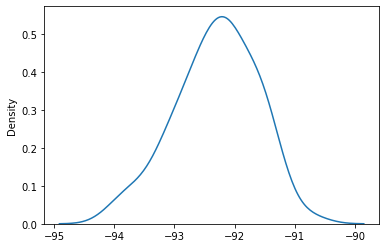

In [ ]:
sns.kdeplot(mix_weights_M.numpy())

In [ ]:
split_joints = mix_weights_M[None, :, None] + predictions_N_M_C[virtual_training_set_size:]

In [ ]:
# predictions_N = torch.argmax(torch.logsumexp(split_joints, dim=1), dim=1)
predictions_N = torch.argmax(torch.sum(split_joints.exp(), dim=1), dim=1)
# predictions_N = torch.argmax(torch.log_softmax(torch.logsumexp(split_joints, dim=1), dim=1), dim=1)

In [ ]:
predictions_N.shape

torch.Size([10005])

In [ ]:
sum(predictions_N == labels_N[virtual_training_set_size:]) / len(predictions_N)

tensor(0.1070)